In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from skimage.feature import hog
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage import data, exposure
from sklearn import datasets, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

In [2]:
image_files = glob.glob(f"5-Categories/*/*.jpg")
print(f"image files: {len(image_files)}")

categories = []
for image_path in image_files:
    category = os.path.basename(os.path.dirname(image_path))
    if category not in categories:
        categories.append(category)
print(f'categories: {len(categories)}')

image files: 374
categories: 5


In [3]:
def load_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128),interpolation =cv2.INTER_LINEAR)
    return image

In [4]:
images = []
labels_list = []
for image_path in image_files:
    # print(f"Processing: {image_path}")
    category = os.path.basename(os.path.dirname(image_path))
    image = load_preprocess_image(image_path)
    images.append(image)
    labels = np.zeros(len(categories))
    labels[categories.index(category)] = 1
    labels_list.append(labels)

#
# Taking first image from each category as the query image
#

query_image_indices: {'buddha': 0, 'cellphone': 85, 'cougar_face': 144, 'crab': 213, 'helicopter': 286}


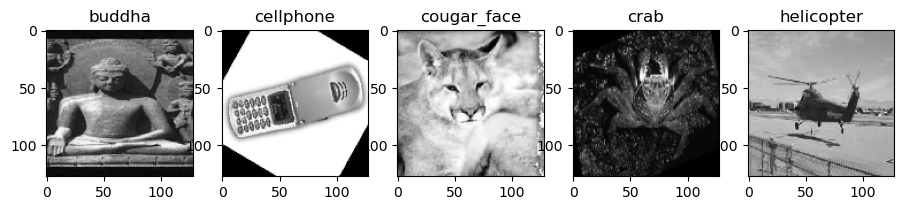

In [18]:
query_image_indices = {}
    
plt.figure(figsize=(20, 15))
j=0
for category in categories:
    for i,image_path in enumerate(image_files):
        if category in image_path:
            query_image_indices[category] = i
            plt.subplot(191+j)
            j=j+1
            plt.imshow(images[i], cmap='gray')
            plt.title(category)
            break
print(f'query_image_indices: {query_image_indices}')
plt.show()

In [23]:
def plot_histogram_distributrion_image(image, category):
    histr = cv2.calcHist([image],[0],None,[256],[0,256]) 
    # show the plotting graph of an image 
    plt.plot(histr), plt.title(category)
    #plt.title(category), plt.xticks([]), plt.yticks([])
    plt.show()    

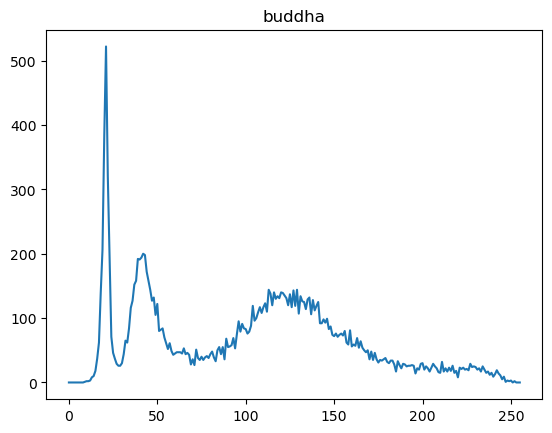

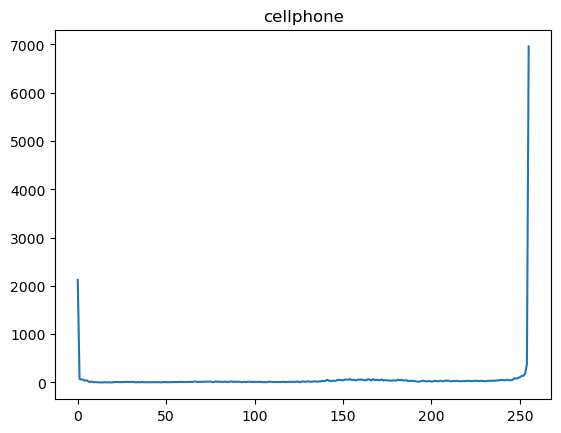

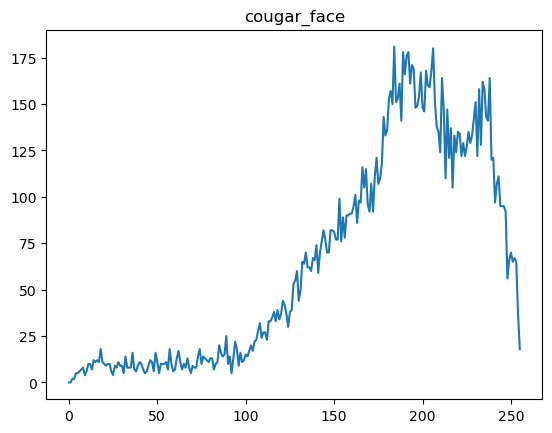

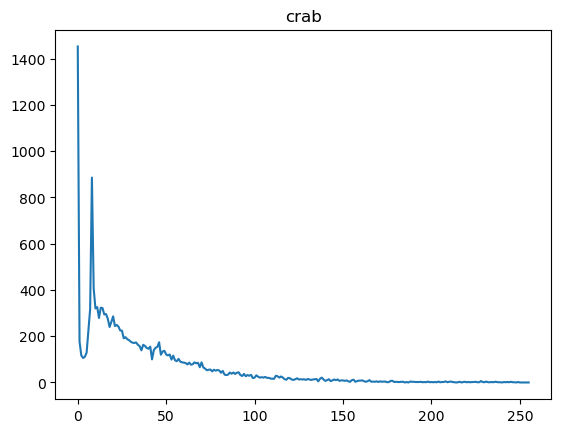

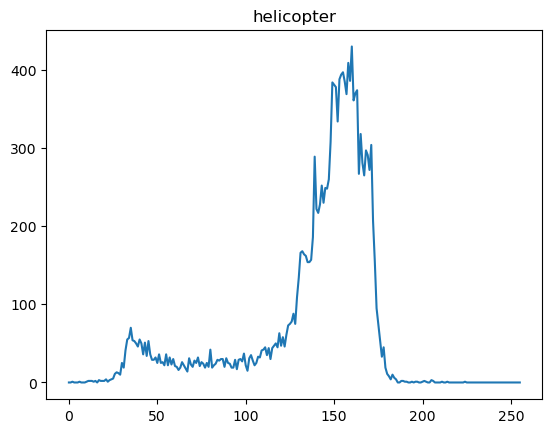

In [24]:
for k,v in query_image_indices.items():
    plot_histogram_distributrion_image(images[v],k)

In [25]:
def plot_original_edge_image(orig_image):
    plt.figure(figsize=(5, 5))
    plt.subplot(121), plt.imshow(orig_image, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    blurred_image = cv2.GaussianBlur(orig_image, (5, 5), 1.4)
    edges = cv2.Canny(blurred_image, 50, 50, 3)
    plt.subplot(122), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

def plot_original_hog_image(orig_image):
    plt.figure(figsize=(5, 5))
    plt.subplot(121), plt.imshow(orig_image, cmap='gray')
    #print(orig_image.shape)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    blurred_image = cv2.GaussianBlur(orig_image, (5, 5), 1.4)
    # hog_image = hog_descriptor.compute(blurred_image)
    fd, hog_image = hog(blurred_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
    #print(hog_image.shape)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    plt.subplot(122), plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title('HOG Image'), plt.xticks([]), plt.yticks([])
    plt.show()

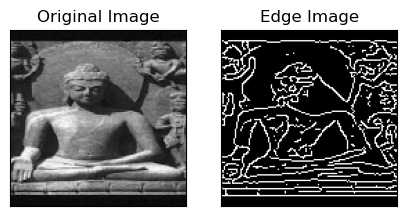

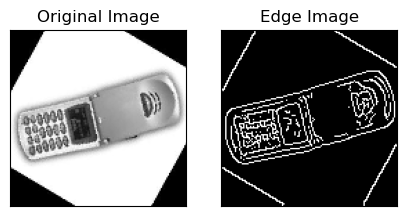

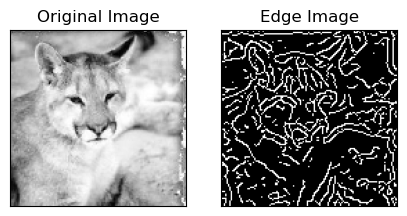

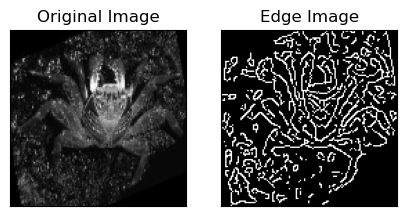

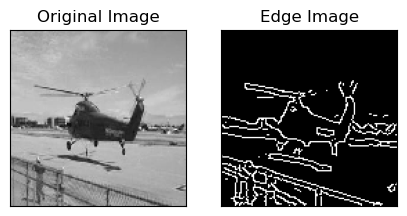

In [28]:
for idx in query_image_indices.values():
    plot_original_edge_image(images[idx])

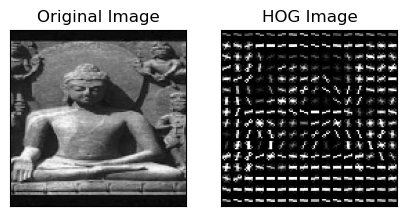

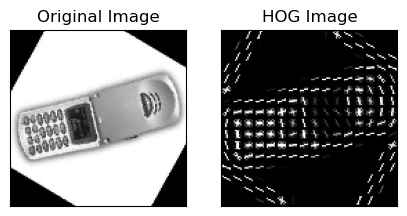

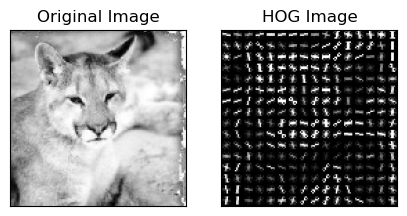

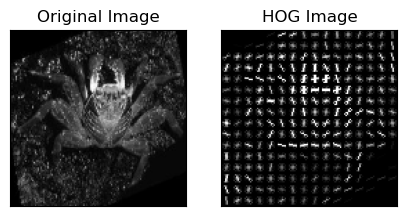

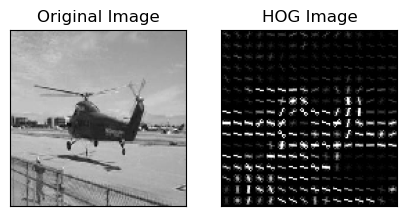

In [29]:
for idx in query_image_indices.values():
    plot_original_hog_image(images[idx])

#
# Generating multiple Feature Sets using different hyper-parameters of Canny Edge and Hog Descriptors
# 

In [30]:
def get_canny_image(image, cp):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)
    edges = cv2.Canny(blurred_image, cp['threshold1'], cp['threshold2'], apertureSize=cp['apertureSize'])
    return edges

def get_hog_features(image, hp):
    blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)
    hog_descriptor = cv2.HOGDescriptor(
        _winSize=(128, 128),
        _blockSize=hp['_blockSize'],
        _blockStride=hp['_blockStride'],
        _cellSize=hp['_cellSize'],
        _nbins=hp['_nbins'] )
    return hog_descriptor.compute(blurred_image)

def get_hog(image, hp):
    blur = cv2.GaussianBlur(image,(5,5),0)
    fd,hog_image = hog(blur, orientations=hp['orientations'], pixels_per_cell=hp['pixels_per_cell'],cells_per_block=hp['cells_per_block'],block_norm= 'L2',visualize=True)
    return fd

def get_histogram_features(image):
    return cv2.calcHist([image],[0],None,[256],[0,256])

def get_image_features(images, cp, hp):
    edge_features = []
    hog_features = []
    hist_features = []
    for image in images:
        canny_edge = get_canny_image(image, cp)
        hog_feature = get_hog(image, hp)
        hist_feature = get_histogram_features(image)
        edge_features.append(canny_edge)
        hog_features.append(hog_feature)
        hist_features.append(hist_feature)
    hog_features = np.array(hog_features)
    edges = np.array(edge_features)
    edge_features = edges.reshape((len(images), -1))
    histr = np.array(hist_features)
    hist_features = histr.reshape((len(images), -1))
    return np.hstack([hog_features,edge_features,hist_features])
    

In [31]:
canny_params = [
    {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3},
    {'threshold1': 100, 'threshold2': 200, 'apertureSize': 3},
    {'threshold1': 150, 'threshold2': 250, 'apertureSize': 5}
]

hog_params = [
    {'_blockSize':(16, 16), '_blockStride':(8, 8),'_cellSize':(8, 8),'_nbins':9},
    {'_blockSize':(16, 16), '_blockStride':(4, 4),'_cellSize':(4, 4),'_nbins':9},
    {'_blockSize':(16, 16), '_blockStride':(8, 8),'_cellSize':(8, 8),'_nbins':12},
    {'_blockSize':(16, 16), '_blockStride':(4, 4),'_cellSize':(4, 4),'_nbins':12},
]

skikit_hog = [
    { 'pixels_per_cell': (4, 4), 'cells_per_block': (1, 1), 'orientations': 8},
    { 'pixels_per_cell': (8, 8), 'cells_per_block': (1, 1), 'orientations': 8},
    { 'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2), 'orientations': 8}

]

feature_sets = []
for cp in canny_params:
    for hp in skikit_hog:
        X = get_image_features(images, cp, hp)
        feature_sets.append({
                    'canny_params': cp,
                    'hog_params': hp,
                    'descriptors': X,
                    'labels_list': labels_list
                })

#
# Training with k-fold cross validation and grid search for optimal hyper-parameters
#

In [51]:
best_acc = 0
best_feature_set = None
best_model = None
best_model_hyperparams = None
best_y_test = None
best_y_test_pred = None
for i,feature_set in enumerate(feature_sets):
    print(f'Training on feature set {i}/{len(feature_sets)-1}:')
    print(f"Canny Params: {feature_set['canny_params']}")
    print(f"Hog Params: {feature_set['hog_params']}")
    
    stratify_labels = np.argmax(feature_set['labels_list'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(feature_set['descriptors'], stratify_labels,#feature_sets[0]['labels_list'], 
                                                    test_size=0.2, random_state=42, stratify=stratify_labels)

    # Define parameter grid for Grid Search
    param_grid = {
        'C': [0.01, 0.05, 0.1, 1, 0.001],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'degree': [2,3,5]
    }
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X_train)
    # pca = PCA(n_components=50)
    # X_reduced = pca.fit_transform(X_train)

    svm = SVC(decision_function_shape='ovr')  # 'ovr' stands for one-vs-rest
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(svm, param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=10)
    grid_search.fit(X_train, y_train)
    best_int_model = grid_search.best_estimator_
    print("Best hyperparameters found: ", grid_search.best_params_)

    # Evaluate on the test set
    # X_test_reduced = pca.fit_transform(X_test)
    y_test_pred = best_int_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test Accuracy: {test_accuracy:.2f}')
    if test_accuracy > best_acc:
        print("*** Updated best model / feature set***")
        best_acc = test_accuracy
        best_feature_set = feature_set
        best_model = best_int_model
        best_model_hyperparams = grid_search.best_params_
        best_y_test = y_test
        best_y_test_pred = y_test_pred
    print()

print(f'Best Canny Params: {best_feature_set["canny_params"]}')
print(f'Best Hog Params: {best_feature_set["hog_params"]}')
print(f'Best Model Hyperparams: {best_model_hyperparams}')
print('Test Classification Report on Best Model:')
print(classification_report(best_y_test, best_y_test_pred))

Training on feature set 0/8:
Canny Params: {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3}
Hog Params: {'pixels_per_cell': (4, 4), 'cells_per_block': (1, 1), 'orientations': 8}
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best hyperparameters found:  {'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.67
*** Updated best model / feature set***

Training on feature set 1/8:
Canny Params: {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3}
Hog Params: {'pixels_per_cell': (8, 8), 'cells_per_block': (1, 1), 'orientations': 8}
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best hyperparameters found:  {'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.67

Training on feature set 2/8:
Canny Params: {'threshold1': 50, 'threshold2': 150, 'apertureSize': 3}
Hog Params: {'pixels_per_cell': (16, 16), 'cells_per_block': (2, 2), 'orientations': 8}
Fitting 3 folds for each of 120 candidates, tota

In [61]:
def plot_best_images(query_image_path, result):
    # Lets see which images we got
    fontdict = {
        'fontsize': 'xx-large',
        'family': 'sans'
    }
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    qlabel = result['label_index']
    q_image = cv2.imread(query_image_path, cv2.IMREAD_COLOR)
    q_image = cv2.cvtColor(q_image, cv2.COLOR_BGR2RGB)
    fontdict['color'] = 'black'
    ax.set_title(f'Query image: {categories[qlabel]}', fontdict=fontdict)
    ax.imshow(q_image)
    
    fig, axs = plt.subplots(1,5, figsize=(20,6))
    for j, index in enumerate(result['similar_candidates']):
        dbimage, dblabel = image_files[index], result['similar_categories'][j]
        image = cv2.imread(dbimage, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = axs[j]
        
        if qlabel == dblabel:
            fontdict['color'] = 'green'
        else:
            fontdict['color'] = 'red'
        
        ax.set_title(categories[dblabel][:20], fontdict=fontdict)
        ax.imshow(image)

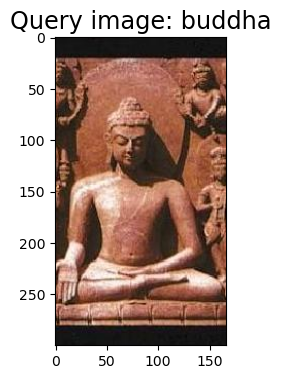

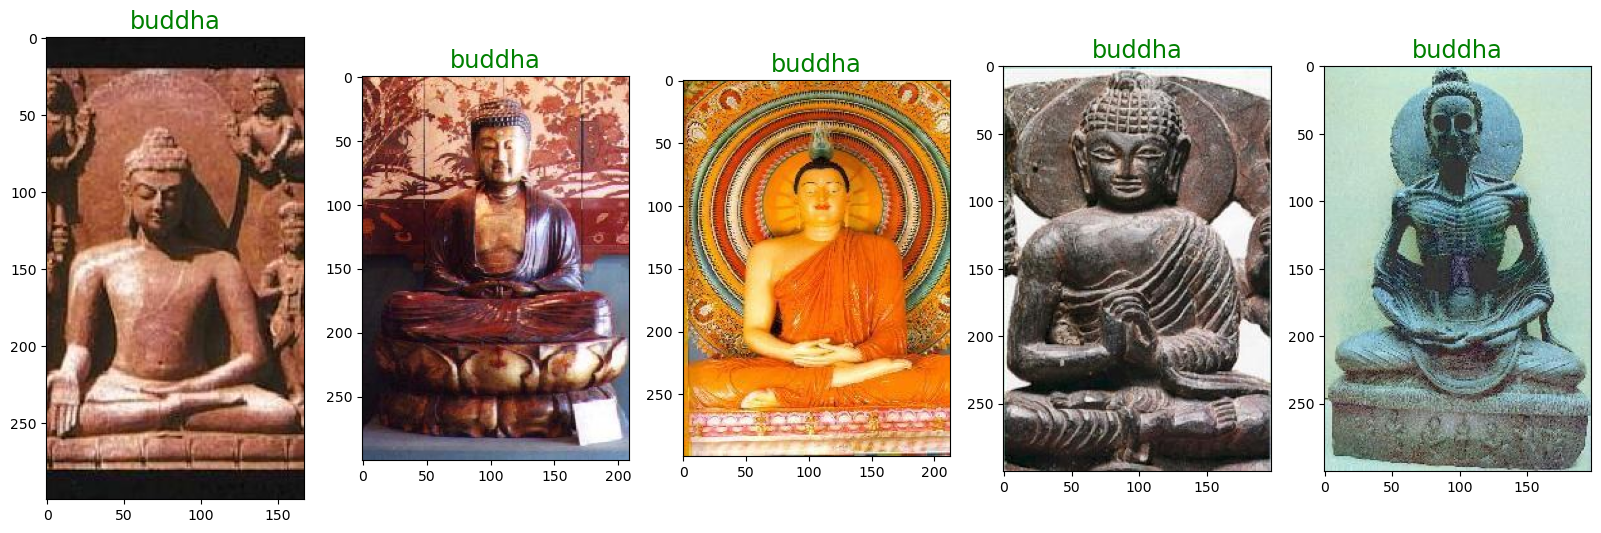

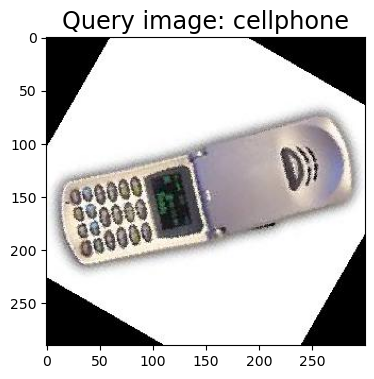

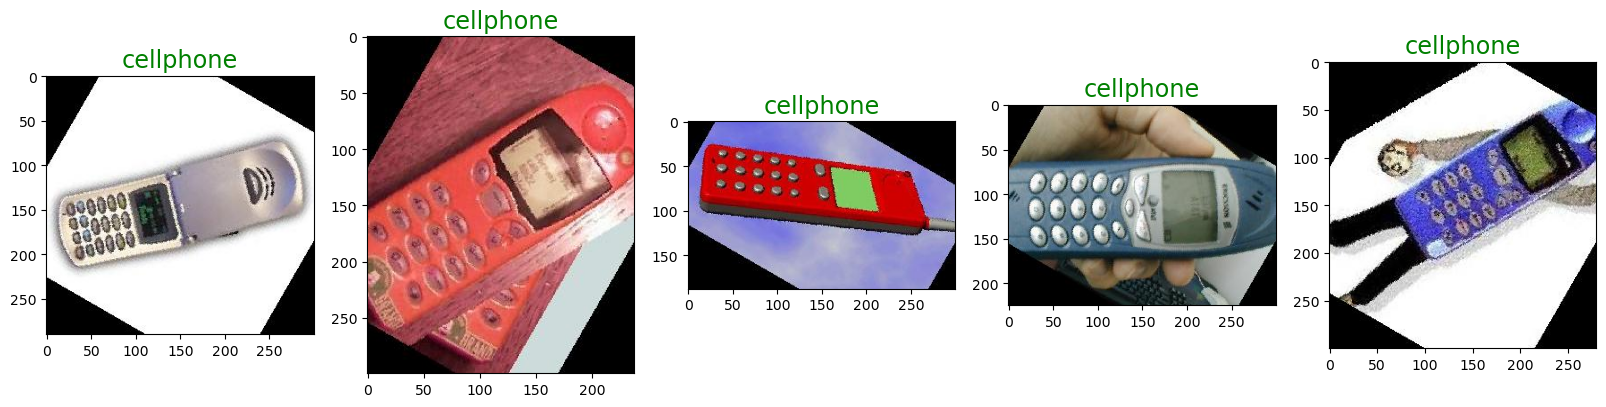

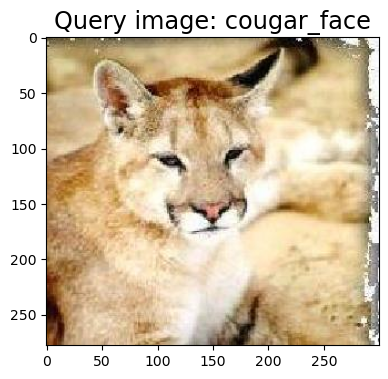

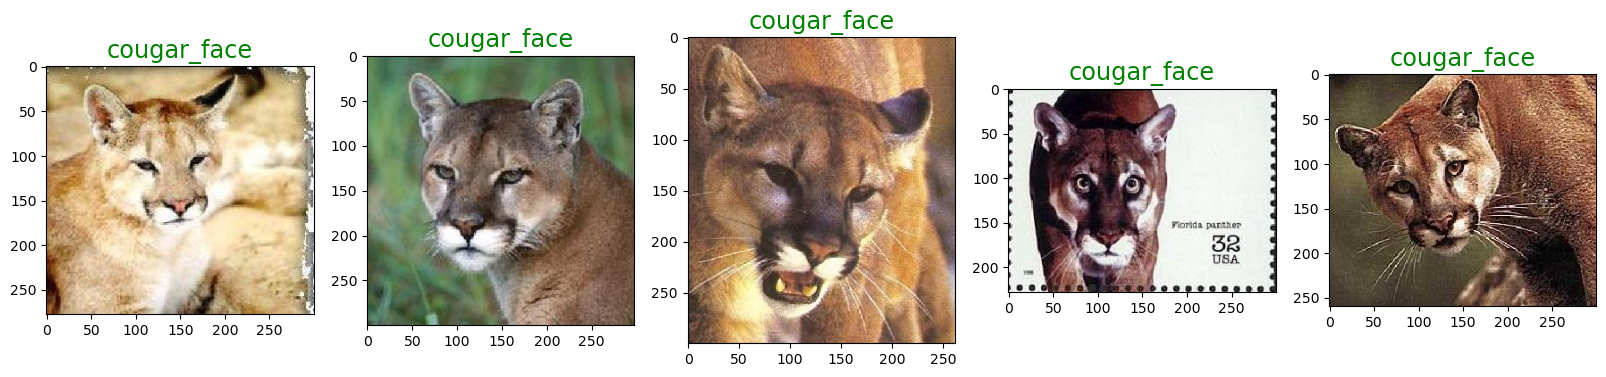

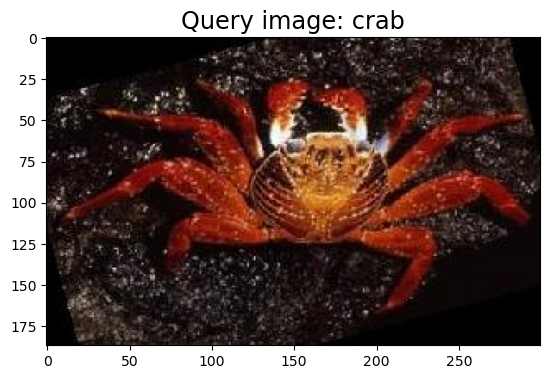

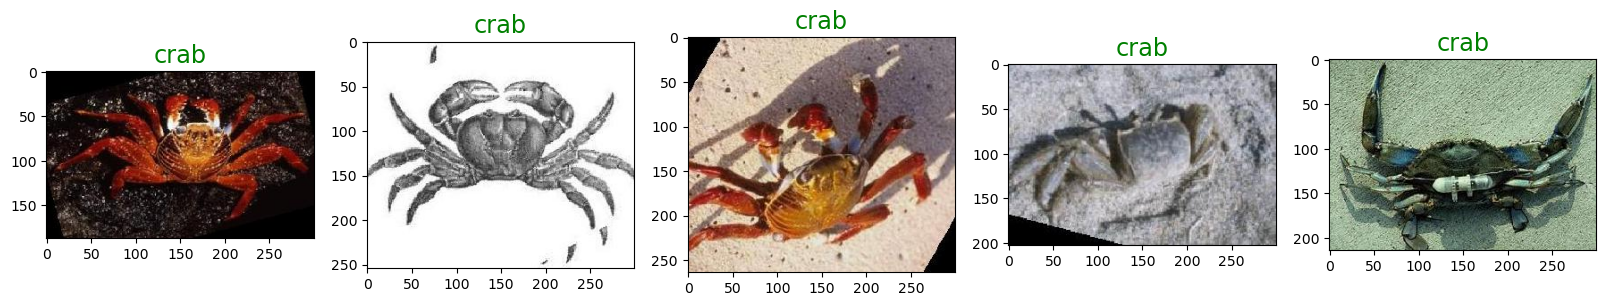

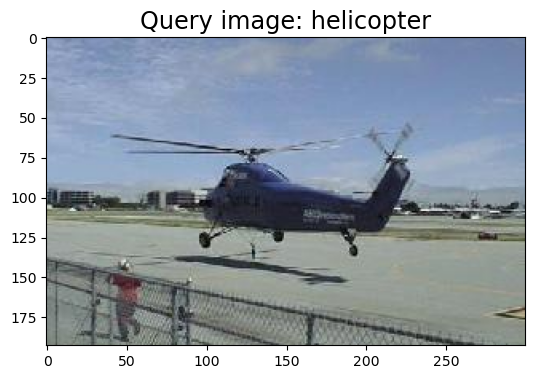

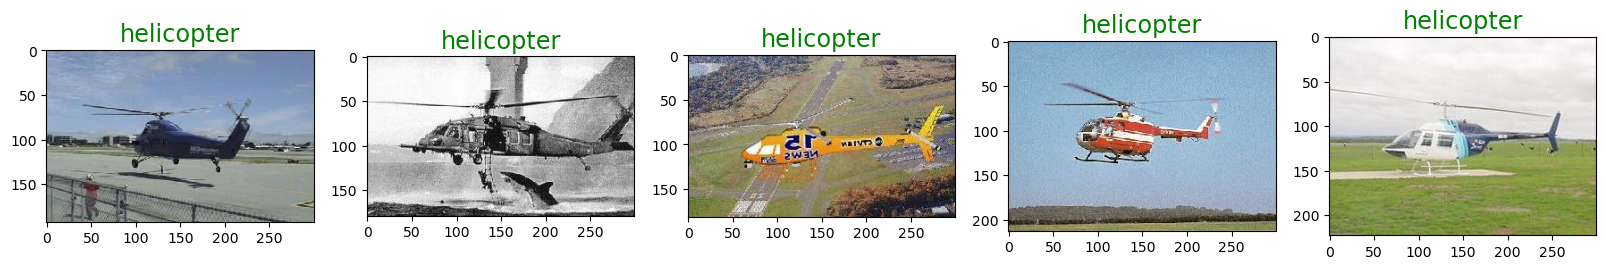

In [62]:
decision_function_values = best_model.decision_function(best_feature_set['descriptors'])
# print(decision_function_values.shape)

for unique_id in query_image_indices.values():    
    query = image_files[unique_id]
    #print(best_feature_set['descriptors'].shape)
    query_features = get_image_features([images[unique_id]], best_feature_set['canny_params'], best_feature_set['hog_params'])
    # print(query_features.shape)
    query_decision_value = best_model.decision_function(query_features)
    distances = pairwise_distances(decision_function_values, query_decision_value)
    
    # Find the indices of the top N similar images
    top_5_indices = np.argsort(distances, axis=0)[:5].flatten()
    #print(stratify_labels[0])
    #print(top_5_indices)
    top_5_categories = [ stratify_labels[i] for i in top_5_indices]
        
    # Get the file paths of the top N similar images
    top_n_images = [images[i] for i in top_5_categories]
    #print(top_5_categories)
    result = { 'label_index': stratify_labels[unique_id], 'similar_candidates': top_5_indices, 'similar_categories': top_5_categories }
    plot_best_images(query, result)